# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
path = "/content/drive/MyDrive/Colab Notebooks/CienciaDeDatos/04_SeriesDeTiempo/Univalle_pm10.csv"

In [8]:
df = pd.read_csv(path)

# Análisis y liempeza básicos

* Examinemos DF

In [9]:
df.head()

,Estacion,Fecha inicial,Fecha final,PM10
0,UNIVERSIDAD DEL VALLE,2021-06-28,NaN,12.800000
1,UNIVERSIDAD DEL VALLE,2021-06-27,NaN,11.516667
2,UNIVERSIDAD DEL VALLE,2021-06-26,NaN,13.316667
3,UNIVERSIDAD DEL VALLE,2021-06-25,NaN,14.020833
4,UNIVERSIDAD DEL VALLE,2021-06-24,NaN,12.916667


* Saquemos un DS solo con el timestamp y valor

In [13]:
df1 = pd.DataFrame(df["PM10"].values, index=df["Fecha inicial"], columns=["PM10"])
df1

,PM10
Fecha inicial,
2021-06-28,12.800000
2021-06-27,11.516667
2021-06-26,13.316667
2021-06-25,14.020833
2021-06-24,12.916667
...,...
2003-12-05,34.100833
2003-12-04,29.288333
2003-12-03,13.869167


* Veamos como se distribuyen lo datos

<Axes: title={'center': ' Distribution of PM10 Regardings'}>

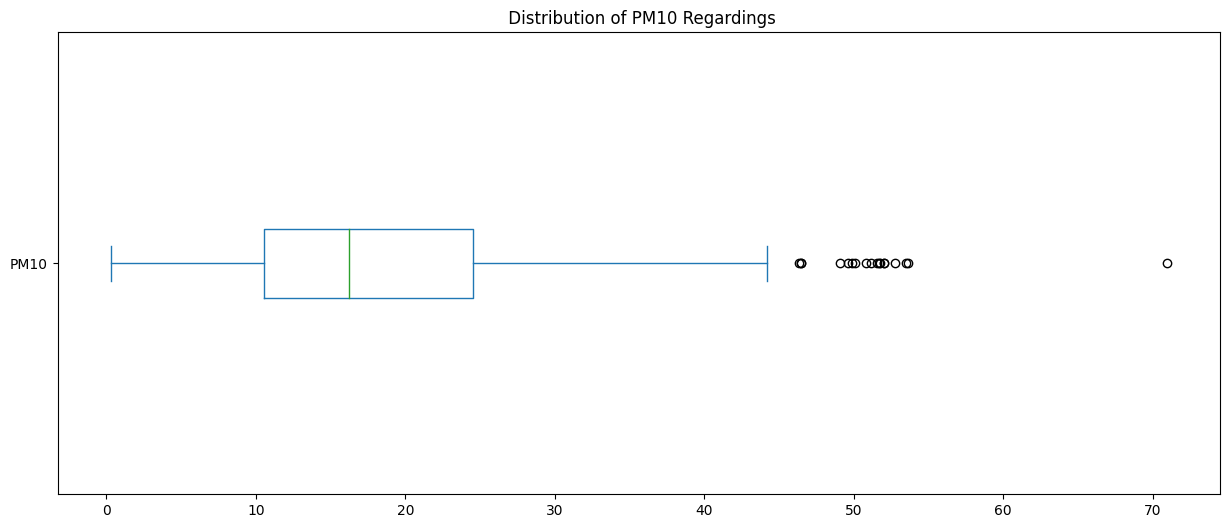

In [15]:
fig, ax = plt.subplots(figsize=(15,6))
df1.PM10.plot(kind="box", vert=False, title=" Distribution of PM10 Regardings", ax=ax)

* Veamos como luce la serie de tiempo

<Axes: title={'center': 'PM1 Time Series'}, xlabel='time', ylabel='PM10'>

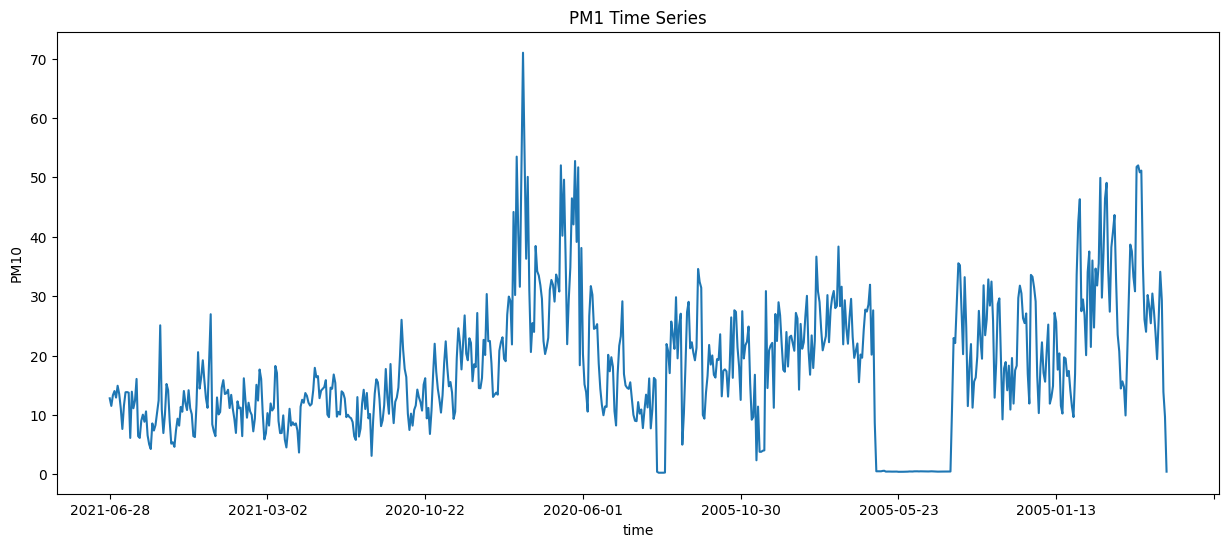

In [17]:
fig, ax = plt.subplots(figsize=(15,6))
df1.PM10.plot(xlabel="time", ylabel="PM10", title="PM1 Time Series", ax=ax)

# Finding Trends

* Pasemos filtro rolling para tomar ventanas y scar la tendencia con media

<Axes: title={'center': 'Monthly Rolling Average'}, xlabel='Fecha inicial', ylabel='PM10'>

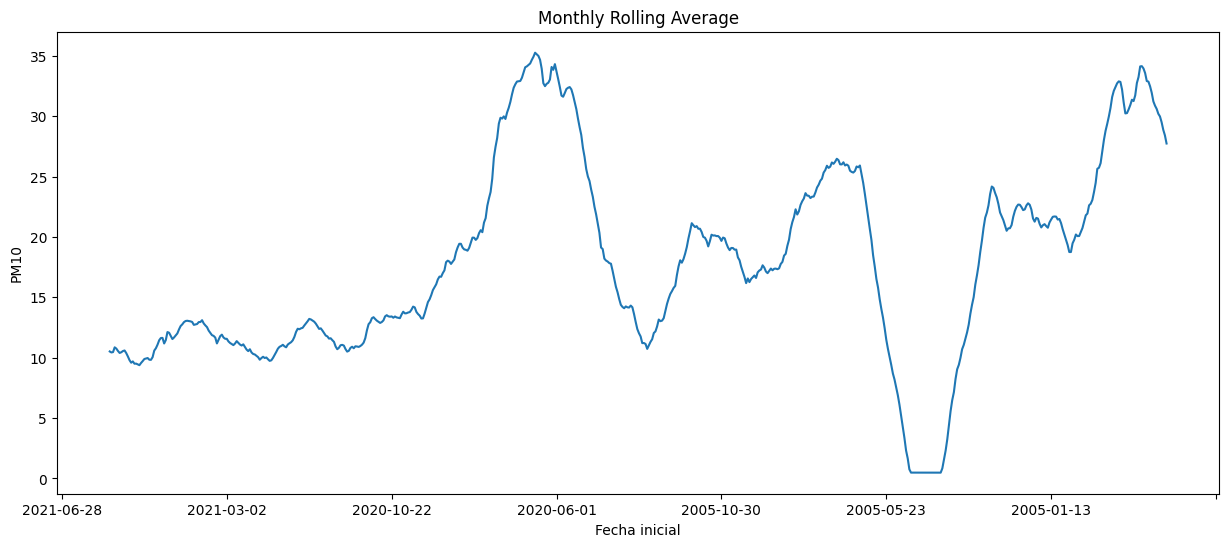

In [18]:
fig, ax = plt.subplots(figsize=(15,6))
df1["PM10"].rolling(30).mean().plot(ax=ax,ylabel="PM10", title="Monthly Rolling Average")

* Quitemos ahora la tendencia

In [20]:
y_deseason = df1["PM10"] - df1["PM10"].rolling(30).mean()

<Axes: title={'center': 'Monthly Rolling Average'}, xlabel='Fecha inicial', ylabel='PM10'>

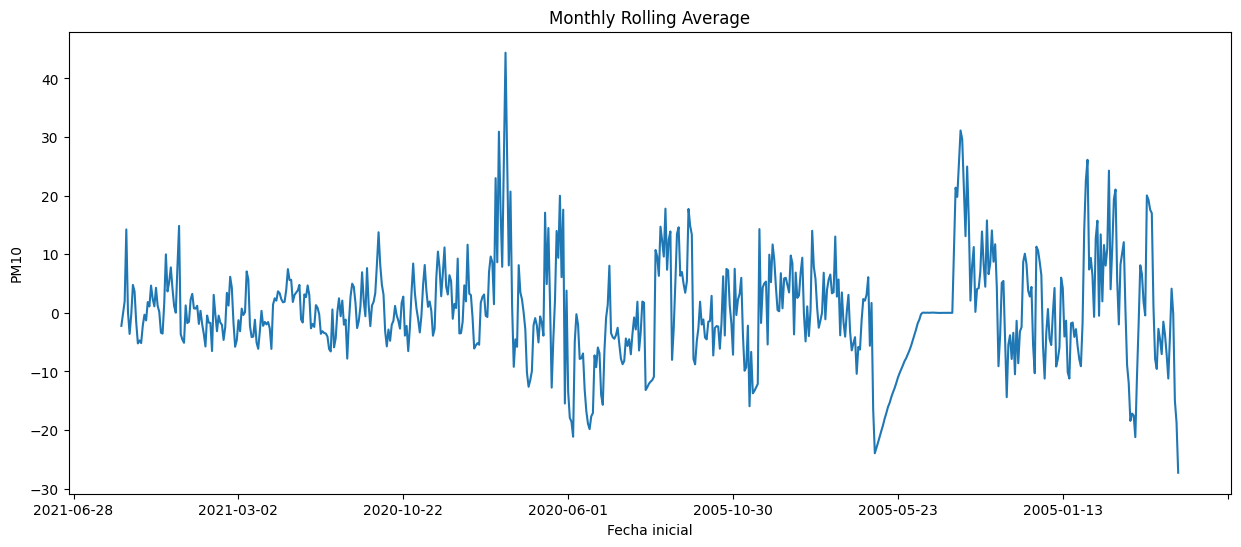

In [21]:
fig, ax = plt.subplots(figsize=(15,6))
y_deseason.plot(ax=ax, ylabel="PM10", title="Monthly Rolling Average")

#ahora se me centro sobre 0, si quiero pueod sumarle el valor DC (valor minimo, asi queda todo positivo)

* Retraso, vamos a leer la informaciónde hace cierto tiempo, en Python se comoce como lag. Retrasamos la informacion por un dia.
 VAMOS de una erie en el tiempo a un DF, que tiene un target, para predecir

In [23]:
df1["PM10.L1"] = df1["PM10"].shift(1) # Lag the signal by one timestamp
df1.dropna().head() #Como estoy retrasado borro la info que no tengo aun

,PM10,PM10.L1
Fecha inicial,,
2021-06-27,11.516667,12.800000
2021-06-26,13.316667,11.516667
2021-06-25,14.020833,13.316667
2021-06-24,12.916667,14.020833
2021-06-23,14.913043,12.916667


* Veo la correlacion par aver que tnto me sirve para predecir los atos del dia de ayer

In [24]:
df1.corr()
#aprox un80% de similaridad par apredecir

,PM10,PM10.L1
PM10,1.000000,0.818405
PM10.L1,0.818405,1.000000


* Gráfico de correlacion entre señal orignal y la retrasaa por un día

Text(0.5, 1.0, 'PM10 Autocorrelation')

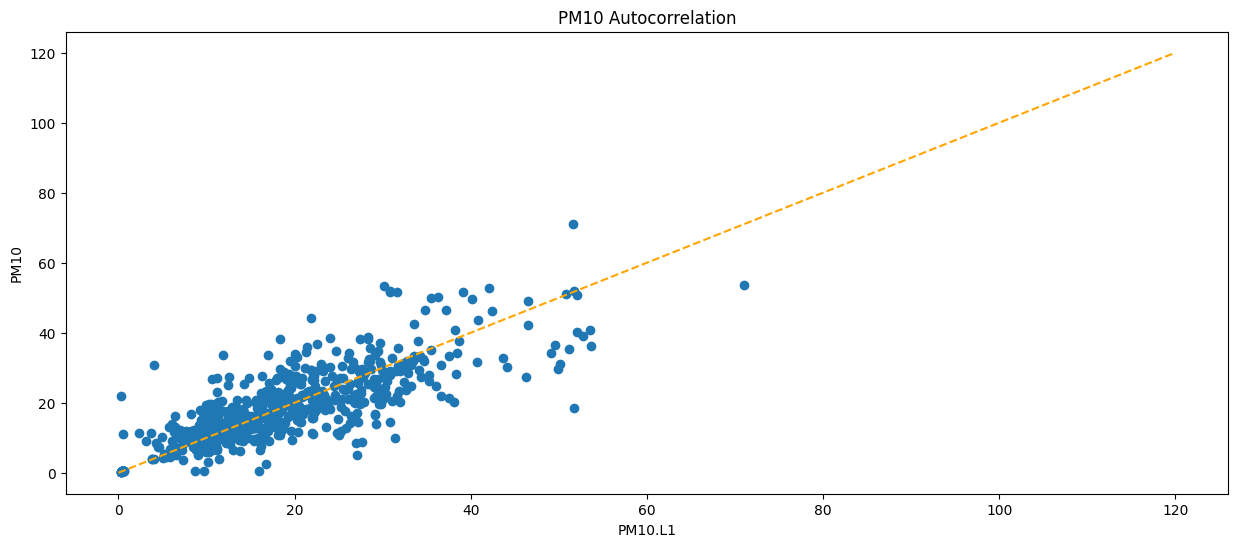

In [25]:
fig, ax = plt.subplots(figsize=(15,6))
ax.scatter(x=df1["PM10.L1"], y=df1["PM10"])
ax.plot([0,120], [0,120], linestyle="--", color = "orange")
plt.xlabel("PM10.L1")
plt.ylabel("PM10")
plt.title("PM10 Autocorrelation")

#Nos lleva a pnsar en una rgresion

# Splitting data

* Split target y patron

In [ ]:
#df.ser_index("Fecha inicial", inplace = True) #si genera algun problema

In [35]:
df2 = df1.dropna()
target = "PM10"
y = df2[target]
X = df2.drop(columns=target)

* Split test  train

In [36]:
cutoff = int(len(X) * 0.8)

X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

# Building a model

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [37]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

# Evaluation

In [38]:
training_mae = mean_absolute_error(y_train, model.predict(X_train))
test_mae =mean_absolute_error(y_test, model.predict(X_test))
print("Training MAE: ", round(training_mae, 2))
print("Test MAE: ", round(test_mae, 2)) #Este es el que presento obviamente se prueba con lo que no conozco

Training MAE:  4.17
Test MAE:  6.24


# COmmunicating results

* Creo nuevo df con valores d eprueba y lo que predice le mdelo con los datos de prueba

In [39]:
df_pred_test = pd.DataFrame(
    {
        "y_test": y_test,
        "y_pred": model.predict(X_test)
    }
)

df_pred_test.head()

,y_test,y_pred
Fecha inicial,,
2005-03-17,28.605833,21.024791
2005-03-16,35.532083,26.359204
2005-03-15,35.203750,32.036881
2005-03-14,27.911250,31.767735
2005-03-13,20.225000,25.789831


* Grafico predicho y esperado

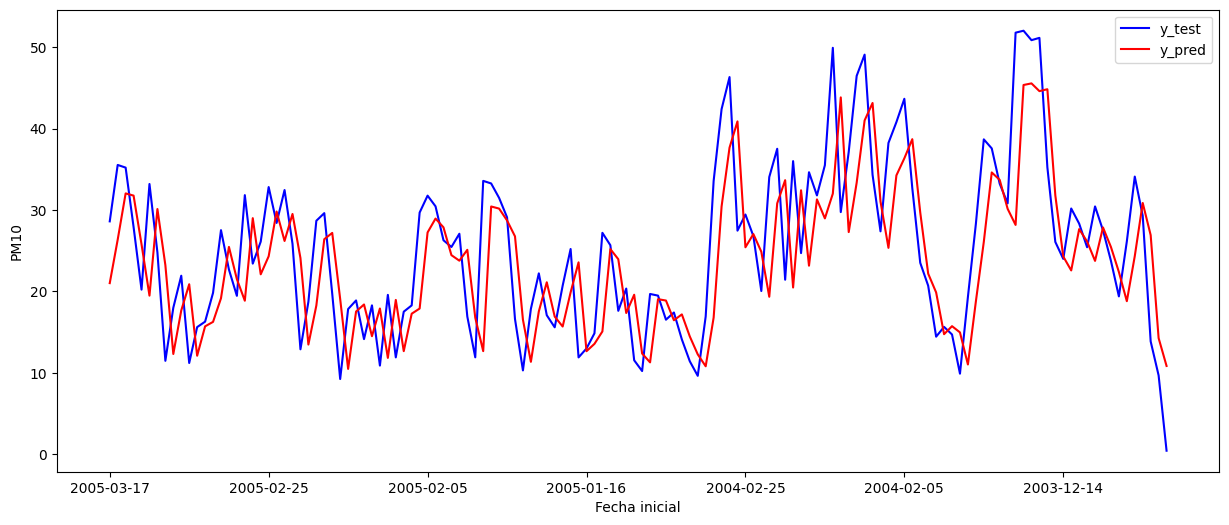

In [41]:
fig, ax = plt.subplots(figsize=(15,6))
df_pred_test.y_test.plot(ax=ax, ylabel="PM10", color="blue");
df_pred_test.y_pred.plot(ax=ax, ylabel="PM10", color="red");
plt.legend()
#dato estan como corridos, logro predecir pero con pequeño retraso

# Autoregressive Models (Cómo mejorar el modelo, metiendo los demas días)

In [43]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

* Gráfico de correlacion de la señal con sus versiones retrasadas de si misma

Text(0, 0.5, 'Correlation Coefficient')

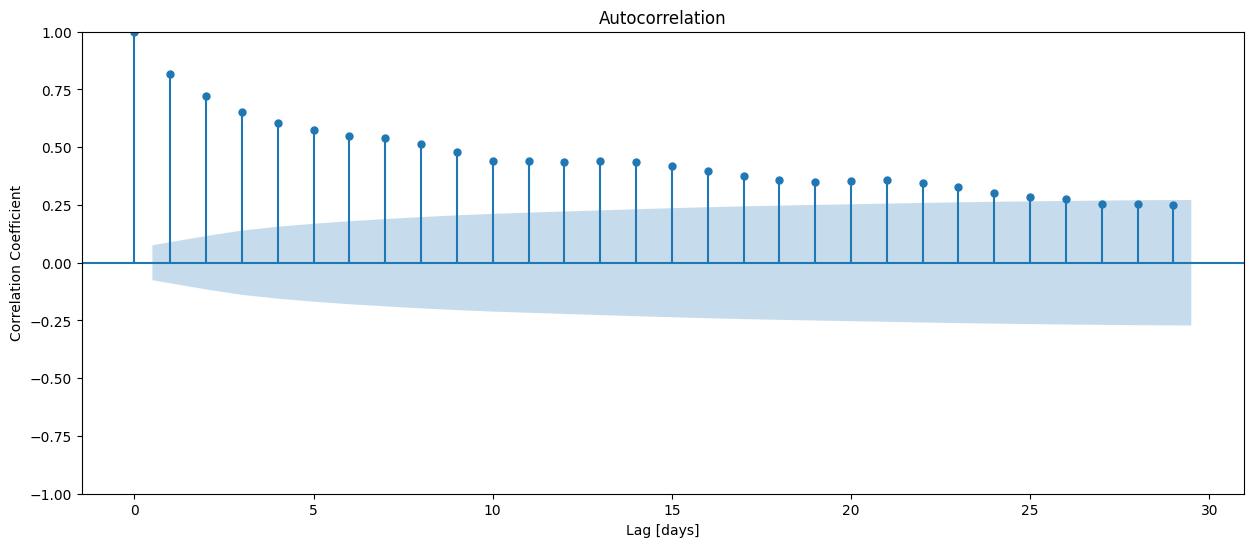

In [46]:
fig, ax = plt.subplots(figsize=(15,6))
plot_acf(y,ax=ax)
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient")

#El cono nos dice donde no es significativa la data, lo que está por dentro ya no tiene fuerza. Señal completamente correlacionada con igo msimo

* Grafica d ecorrelacion parcial

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Text(0, 0.5, 'Correlation Coefficient')

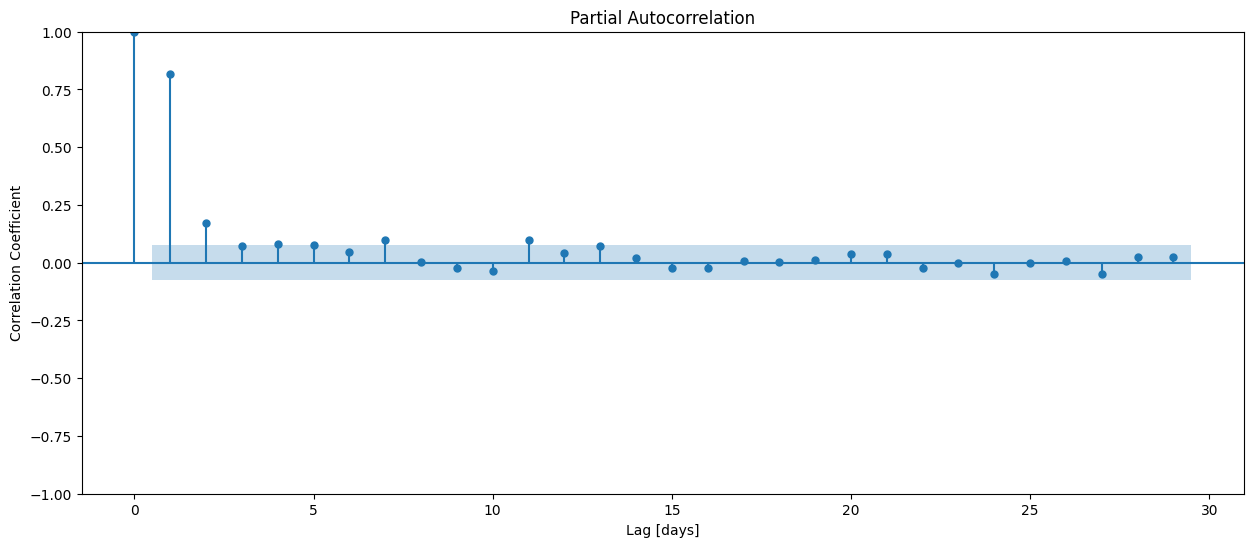

In [47]:
fig, ax = plt.subplots(figsize=(15,6))
plot_pacf(y,ax=ax)
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient")

#señal con correlacionada cada retraso, retrso 1,2,n y vuelvo a correlaciona. Es decir, hay información
#de algunos retrasos contenida en otras. Esto para disminuir la dimensionalidad

# Building an autoregressive model

In [49]:
from statsmodels.tsa.ar_model import AutoReg

In [51]:
model = AutoReg(y_train, lags=11).fit() #El solo encuentra corelaciones y tales, lo le digo como usarlos

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
